In [47]:
import pandas as pd
import csv
from scipy import spatial, stats
from sklearn import linear_model
import numpy as np
import re

In [48]:
# only need to run this cell if unzip is needed
import zipfile
def unzip(path_to_zip_file):
    zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
    zip_ref.extractall("data/")
    zip_ref.close()
    
unzip("data/attributes.csv.zip")
unzip("data/product_descriptions.csv.zip")
unzip("data/sample_submission.csv.zip")
unzip("data/train.csv.zip")
unzip("data/test.csv.zip")

In [49]:
df_attributes = pd.read_csv("data/attributes.csv")
df_product_desc = pd.read_csv("data/product_descriptions.csv")
df_sample_submission = pd.read_csv("data/sample_submission.csv")
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


def read_csv_to_list(filename):
    with open(filename, 'rb') as f:
        reader = csv.reader(f, )
        l = list(reader)
        return l[1:]  # omit header

attributes = read_csv_to_list("data/attributes.csv")
product_desc = read_csv_to_list("data/product_descriptions.csv")
train = read_csv_to_list("data/train.csv")
test = read_csv_to_list("data/test.csv")

In [50]:
df_attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [51]:
df_product_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [52]:
df_sample_submission.head()

,id,relevance
0,1,1
1,4,1
2,5,1
3,6,1
4,7,1


In [53]:
print df_train.shape
df_train.head()

(74067, 5)


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


Ideas for better parsing of tokens:
> camelCase split -> camel case

> alpha numeric strings into alpha and numeric sections (g15 -> g 15)

> for indexing step do selective indexing

In [54]:
print df_test.shape
df_test.head()

(166693, 4)


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [55]:
def generate_token_map(data, tokens, idx, row_len):
    num_rows = len(data)
    for i, row in enumerate(data):
        assert len(row) == row_len, row
        for token in re.sub('[^0-9a-zA-Z]+', ' ', row[2]).lower().split(" "):
            if token not in tokens.keys():
                tokens[token] = idx
                idx += 1
        for token in re.sub('[^0-9a-zA-Z]+', ' ', row[3]).lower().split(" "):
            if token not in tokens.keys():
                tokens[token] = idx
                idx += 1
        if i % 1000 == 0:
            print "added to token map for {} rows out of {}".format(i, num_rows)
#         if i == 50000:
#             break
    return tokens, idx

4min 39sec

In [56]:
%%time 
tokens, idx = generate_token_map(train, {}, 0, 5)

added to token map for 0 rows out of 74067
added to token map for 1000 rows out of 74067
added to token map for 2000 rows out of 74067
added to token map for 3000 rows out of 74067
added to token map for 4000 rows out of 74067
added to token map for 5000 rows out of 74067
added to token map for 6000 rows out of 74067
added to token map for 7000 rows out of 74067
added to token map for 8000 rows out of 74067
added to token map for 9000 rows out of 74067
added to token map for 10000 rows out of 74067
added to token map for 11000 rows out of 74067
added to token map for 12000 rows out of 74067
added to token map for 13000 rows out of 74067
added to token map for 14000 rows out of 74067
added to token map for 15000 rows out of 74067
added to token map for 16000 rows out of 74067
added to token map for 17000 rows out of 74067
added to token map for 18000 rows out of 74067
added to token map for 19000 rows out of 74067
added to token map for 20000 rows out of 74067
added to token map for 210

25min 21s

In [57]:
%%time
tokens, idx = generate_token_map(test, tokens, idx, 4)

added to token map for 0 rows out of 166693
added to token map for 1000 rows out of 166693
added to token map for 2000 rows out of 166693
added to token map for 3000 rows out of 166693
added to token map for 4000 rows out of 166693
added to token map for 5000 rows out of 166693
added to token map for 6000 rows out of 166693
added to token map for 7000 rows out of 166693
added to token map for 8000 rows out of 166693
added to token map for 9000 rows out of 166693
added to token map for 10000 rows out of 166693
added to token map for 11000 rows out of 166693
added to token map for 12000 rows out of 166693
added to token map for 13000 rows out of 166693
added to token map for 14000 rows out of 166693
added to token map for 15000 rows out of 166693
added to token map for 16000 rows out of 166693
added to token map for 17000 rows out of 166693
added to token map for 18000 rows out of 166693
added to token map for 19000 rows out of 166693
added to token map for 20000 rows out of 166693
added

In [58]:
print idx

32049


In [59]:
def generate_space(data, idx):
    num_rows = len(data)
    product_title_space = []
    search_term_space = []
    indices = []
    for i, row in enumerate(data):
        indices.append(row[0])
        product_title_vector = [0]*idx
        for token in re.sub('[^0-9a-zA-Z]+', ' ', row[2]).lower().split(" "):
            j = tokens.get(token)
            product_title_vector[j] = 1
        product_title_space.append(product_title_vector)

        search_term_vector = [0]*idx
        for token in re.sub('[^0-9a-zA-Z]+', ' ', row[3]).lower().split(" "):
            j = tokens.get(token)
            search_term_vector[j] = 1
        search_term_space.append(search_term_vector)

        if i % 1000 == 0 and i != 0:
            print "generated space for {} rows out of {}".format(i, num_rows)
#         if i == 50000:
#             break
    return product_title_space, search_term_space, indices

11min 9s

In [60]:
%%time
product_title_space, search_term_space, indices = generate_space(train, idx)

generated space for 1000 rows out of 74067
generated space for 2000 rows out of 74067
generated space for 3000 rows out of 74067
generated space for 4000 rows out of 74067
generated space for 5000 rows out of 74067
generated space for 6000 rows out of 74067
generated space for 7000 rows out of 74067
generated space for 8000 rows out of 74067
generated space for 9000 rows out of 74067
generated space for 10000 rows out of 74067
generated space for 11000 rows out of 74067
generated space for 12000 rows out of 74067
generated space for 13000 rows out of 74067
generated space for 14000 rows out of 74067
generated space for 15000 rows out of 74067
generated space for 16000 rows out of 74067
generated space for 17000 rows out of 74067
generated space for 18000 rows out of 74067
generated space for 19000 rows out of 74067
generated space for 20000 rows out of 74067
generated space for 21000 rows out of 74067
generated space for 22000 rows out of 74067
generated space for 23000 rows out of 740

In [61]:
# pd.DataFrame(product_title_space).head()

In [62]:
# pd.DataFrame(search_term_space).head()

In [63]:
def get_cos_dists(data, product_title_space, search_term_space, train=True):
    num_rows = len(data)
    cos_dists = []
    actual_relevance = []
    for i, row in enumerate(data):
        cos_dists.append(spatial.distance.cosine(product_title_space[i], search_term_space[i]))
        if train:
            actual_relevance.append(float(row[4]))
        if i % 1000 == 0 and i != 0:
            print "found cos dist for {} rows out of {}".format(i, num_rows)
#         if i == 50000:
#             break
    return cos_dists, actual_relevance

4min 7s

In [64]:
%%time
cos_dists, actual_relevance = get_cos_dists(train, product_title_space, search_term_space)

found cos dist for 1000 rows out of 74067
found cos dist for 2000 rows out of 74067
found cos dist for 3000 rows out of 74067
found cos dist for 4000 rows out of 74067
found cos dist for 5000 rows out of 74067
found cos dist for 6000 rows out of 74067
found cos dist for 7000 rows out of 74067
found cos dist for 8000 rows out of 74067
found cos dist for 9000 rows out of 74067
found cos dist for 10000 rows out of 74067
found cos dist for 11000 rows out of 74067
found cos dist for 12000 rows out of 74067
found cos dist for 13000 rows out of 74067
found cos dist for 14000 rows out of 74067
found cos dist for 15000 rows out of 74067
found cos dist for 16000 rows out of 74067
found cos dist for 17000 rows out of 74067
found cos dist for 18000 rows out of 74067
found cos dist for 19000 rows out of 74067
found cos dist for 20000 rows out of 74067
found cos dist for 21000 rows out of 74067
found cos dist for 22000 rows out of 74067
found cos dist for 23000 rows out of 74067
found cos dist for 2

In [65]:
print cos_dists[0:10]
print actual_relevance[0:10]

[0.71132486540518713, 1.0, 1.0, 0.85092880150001404, 0.55278640450004202, 0.82322330470336313, 0.71132486540518713, 1.0, 0.55278640450004213, 0.49999999999999989]
[3.0, 2.5, 3.0, 2.33, 2.67, 3.0, 2.67, 3.0, 2.67, 3.0]


In [66]:
x_train = np.array(cos_dists)
y_train = np.array(actual_relevance)
print x_train.shape
print y_train.shape
print type(x_train)
print type(y_train)

(74067,)
(74067,)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [67]:
slope, intercept, r_value, p_value, std_err = -0.801760196922, 2.95084125499, -0.256012628357, 0.0, 0.0111238820463

In [68]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_train,y_train)

In [69]:
print slope, intercept, r_value, p_value, std_err

-0.801760196922 2.95084125499 -0.256012628357 0.0 0.0111238820463


In [70]:
np.corrcoef(cos_dists, actual_relevance)

array([[ 1.        , -0.25601263],
       [-0.25601263,  1.        ]])

In [71]:
print x_train[0:10]*slope+intercept
print y_train[0:10]

[ 2.38052929  2.14908106  2.14908106  2.26860041  2.50763912  2.29081358
  2.38052929  2.14908106  2.50763912  2.54996116]
[ 3.    2.5   3.    2.33  2.67  3.    2.67  3.    2.67  3.  ]


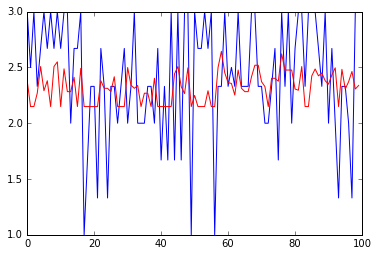

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(0,100),y_train[0:100])
plt.plot(range(0,100),x_train[0:100]*slope+intercept, color='red')
plt.show()

In [26]:
#free up memory
product_title_space = None
search_term_space = None
indices = None
cos_dists = None

In [27]:
def predict_score(test, idx, filename="data/cosine_dist.csv"):
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id", "relevance"])
    num_rows = len(test)
    for i, row in enumerate(test):
        product_title_space, search_term_space, indices = generate_space([row], idx)
        cos_dists, _ = get_cos_dists([row], product_title_space, search_term_space, train=False)
        x_test = np.array(cos_dists)
        predicted_scores = x_test*slope+intercept
        with open(filename, 'a') as f:
            writer = csv.writer(f)
            for j, score in enumerate(predicted_scores):
                writer.writerow([indices[j], score])
        if i % 1000 == 0 and i != 0:
            print "wrote to file for {} rows out of {}".format(i, num_rows)
    return predicted_scores

25min 51s

In [28]:
%%time
predict_score(test, idx)

wrote to file for 1000 rows out of 166693
wrote to file for 2000 rows out of 166693
wrote to file for 3000 rows out of 166693
wrote to file for 4000 rows out of 166693
wrote to file for 5000 rows out of 166693
wrote to file for 6000 rows out of 166693
wrote to file for 7000 rows out of 166693
wrote to file for 8000 rows out of 166693
wrote to file for 9000 rows out of 166693
wrote to file for 10000 rows out of 166693
wrote to file for 11000 rows out of 166693
wrote to file for 12000 rows out of 166693
wrote to file for 13000 rows out of 166693
wrote to file for 14000 rows out of 166693
wrote to file for 15000 rows out of 166693
wrote to file for 16000 rows out of 166693
wrote to file for 17000 rows out of 166693
wrote to file for 18000 rows out of 166693
wrote to file for 19000 rows out of 166693
wrote to file for 20000 rows out of 166693
wrote to file for 21000 rows out of 166693
wrote to file for 22000 rows out of 166693
wrote to file for 23000 rows out of 166693
wrote to file for 24

array([ 2.60363636])

In [14]:
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

In [35]:
print diabetes_X_train.shape

(422, 1)


In [47]:
print diabetes_y_train.shape

(422,)


In [80]:
x_train = np.array(cos_dists).reshape(len(cos_dists),1)
y_train = np.array(actual_relevance).reshape(len(actual_relevance),1)
print x_train.shape
print y_train.shape
print type(x_train)
print type(y_train)

(74067, 1)
(74067, 1)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [27]:
x_test = np.array(cos_dists)
y_test = np.array(actual_relevance)

Accuracy: 0.03 (+/- 0.12)
('Coefficients: \n', array([[-0.8017602]]))
Residual sum of squares: 0.27
Variance score: 0.07


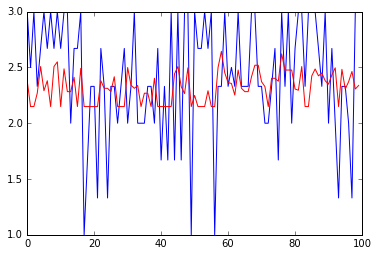

In [96]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

from sklearn import cross_validation
scores = cross_validation.cross_val_score(regr, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_train, y_train))

# Plot outputs
# plt.scatter(x_train[0:100], y_train[0:100],  color='black')
# plt.plot(x_train[0:100], regr.predict(x_train)[0:100], color='blue',
#          linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.plot(range(0,100),y_train[0:100])
plt.plot(range(0,100),regr.predict(x_train)[0:100], color='red')
plt.show()

plt.show()